imports + configs globales

In [28]:
import os, glob, time, warnings, sys, platform, multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import clone

from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120


Reproducibility & environment (sans doublons)

In [29]:
print("=== Reproducibility ===")
print("Python version   :", sys.version.split()[0])
print("Platform         :", platform.platform())
print("CPU cores        :", multiprocessing.cpu_count())
print("NumPy version    :", np.__version__)
print("scikit-learn ver :", sklearn.__version__)
print("XGBoost version  :", xgb.__version__)
print("Random seed      :", RANDOM_STATE)


=== Reproducibility ===
Python version   : 3.10.18
Platform         : macOS-11.3.1-arm64-arm-64bit
CPU cores        : 8
NumPy version    : 1.26.4
scikit-learn ver : 1.6.1
XGBoost version  : 3.1.2
Random seed      : 42


Paramètres d’expérience

In [30]:
SEGMENTS_DIR = "preprocessed_data/segments"
RAW_SIGNAL_COLS_CANDIDATES = ["Speed", "turning_angle"]  # pas X,Y
NEAR_DEATH_N_SEGMENTS = 20
TARGET_LEN = 900

USE_SMALL_SUBSET = False
SMALL_SUBSET_SIZE = 3000
MAX_FILES = None


Vérification fichiers + colonnes

In [31]:
files = glob.glob(os.path.join(SEGMENTS_DIR, "*.csv"))
if MAX_FILES is not None:
    files = files[:MAX_FILES]

print(f"Found {len(files)} segment files in {SEGMENTS_DIR}")
if len(files) == 0:
    raise RuntimeError("No segment CSV found. Check SEGMENTS_DIR path.")

df_ex = pd.read_csv(files[0])
print("Example file:", os.path.basename(files[0]))
print("Columns:", df_ex.columns.tolist())

raw_cols = [c for c in RAW_SIGNAL_COLS_CANDIDATES if c in df_ex.columns]
if len(raw_cols) == 0:
    raise RuntimeError(f"None of {RAW_SIGNAL_COLS_CANDIDATES} found in segment CSV columns.")

print("Using raw signal columns:", raw_cols)


Found 8150 segment files in preprocessed_data/segments
Example file: coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv
Columns: ['GlobalFrame', 'Timestamp', 'Speed', 'X', 'Y', 'condition', 'source_file', 'Segment_index', 'turning_angle', 'worm_id', 'Segment']
Using raw signal columns: ['Speed', 'turning_angle']


Loader robuste (padding/troncature) + métadonnées

In [32]:
def load_segments_featureless(files, raw_cols, target_len=900):
    X_list, worm_ids, seg_idx = [], [], []
    lengths = []
    skipped = 0

    for fp in files:
        try:
            df = pd.read_csv(fp)
        except Exception:
            skipped += 1
            continue

        if "worm_id" not in df.columns:
            skipped += 1
            continue

        if "Segment_index" in df.columns:
            sidx = df["Segment_index"].iloc[0]
        elif "Segment" in df.columns:
            sidx = df["Segment"].iloc[0]
        else:
            skipped += 1
            continue

        Xraw = df[raw_cols].to_numpy(dtype=float)
        Xraw = np.nan_to_num(Xraw, nan=0.0, posinf=0.0, neginf=0.0)

        L = Xraw.shape[0]
        lengths.append(L)

        C = Xraw.shape[1]
        arr = np.zeros((target_len, C), dtype=float)
        if L >= target_len:
            arr[:] = Xraw[:target_len, :]
        else:
            arr[:L, :] = Xraw

        X_list.append(arr)
        worm_ids.append(df["worm_id"].iloc[0])
        seg_idx.append(int(float(sidx)))

    X = np.stack(X_list, axis=0)  # (N,T,C)
    worm_ids = np.array(worm_ids)
    seg_idx = np.array(seg_idx, dtype=int)

    info = {
        "N": len(X_list),
        "skipped": skipped,
        "min_len": int(np.min(lengths)) if lengths else None,
        "max_len": int(np.max(lengths)) if lengths else None,
        "n_worms": int(len(np.unique(worm_ids)))
    }
    return X, worm_ids, seg_idx, info

X_raw, worm_ids, segment_indices, info = load_segments_featureless(files, raw_cols, target_len=TARGET_LEN)
print("Load info:", info)
print("X_raw shape:", X_raw.shape, "(N,T,C)")
print("Unique worms:", len(np.unique(worm_ids)))


Load info: {'N': 8150, 'skipped': 0, 'min_len': 2, 'max_len': 901, 'n_worms': 104}
X_raw shape: (8150, 900, 2) (N,T,C)
Unique worms: 104


Labels near-death (derniers N segments, sans lifespan externe)

In [33]:
segments_from_end = np.zeros_like(segment_indices, dtype=int)

for wid in np.unique(worm_ids):
    mask = (worm_ids == wid)
    idxs = segment_indices[mask]
    max_seg = idxs.max()
    segments_from_end[mask] = max_seg - idxs

y = (segments_from_end <= NEAR_DEATH_N_SEGMENTS).astype(int)

print("Label distribution (0=far, 1=near):", np.bincount(y))
print("Positive rate:", y.mean())


Label distribution (0=far, 1=near): [6016 2134]
Positive rate: 0.261840490797546


Flatten + subset optionnel + groups

In [34]:
N, T, C = X_raw.shape
X_flat = X_raw.reshape(N, T * C)
groups = worm_ids

if USE_SMALL_SUBSET:
    n = min(SMALL_SUBSET_SIZE, N)
    idx_sub = np.random.choice(N, size=n, replace=False)
    X_used = X_flat[idx_sub]
    y_used = y[idx_sub]
    groups_used = groups[idx_sub]
    print("Using subset:", X_used.shape, np.bincount(y_used))
else:
    X_used, y_used, groups_used = X_flat, y, groups
    print("Using full data:", X_used.shape, np.bincount(y_used))

print("n_worms:", len(np.unique(groups_used)))


Using full data: (8150, 1800) [6016 2134]
n_worms: 104


Dummy baseline (grouped CV)

In [35]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, aucs = [], [], []
for tr, te in cv.split(X_used, y_used, groups=groups_used):
    dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    dummy.fit(X_used[tr], y_used[tr])
    proba = dummy.predict_proba(X_used[te])[:, 1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(y_used[te], pred))
    f1s.append(f1_score(y_used[te], pred))
    aucs.append(roc_auc_score(y_used[te], proba))

print("=== Dummy (stratified) grouped CV ===")
print(f"ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


=== Dummy (stratified) grouped CV ===
ACC: 0.618 ± 0.008
F1 : 0.274 ± 0.016
AUC: 0.508 ± 0.008


Modèles (model zoo)

In [36]:
models = {}

models["LogReg_l2"] = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

models["HistGB"] = HistGradientBoostingClassifier(
    learning_rate=0.1, max_depth=3, max_iter=300,
    class_weight="balanced", random_state=RANDOM_STATE
)

models["RandomForest"] = RandomForestClassifier(
    n_estimators=600, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

models["ExtraTrees"] = ExtraTreesClassifier(
    n_estimators=800, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

models["SVM_RBF_PCA100"] = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100, random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced",
               probability=True, random_state=RANDOM_STATE))
])

models["XGBoost"] = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE
)


Fonction CV groupée (BUG FIXÉ)

In [37]:
def grouped_cv_eval(model, X, y, groups, n_splits=5):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    accs, f1s, aucs, times = [], [], [], []

    for tr, te in cv.split(X, y, groups=groups):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        m = clone(model)

        t0 = time.time()
        m.fit(X_tr, y_tr)
        times.append(time.time() - t0)

        proba = m.predict_proba(X_te)[:, 1]
        pred = (proba >= 0.5).astype(int)

        accs.append(accuracy_score(y_te, pred))
        f1s.append(f1_score(y_te, pred))
        aucs.append(roc_auc_score(y_te, proba))

    return {
        "ACC_mean": np.mean(accs), "ACC_std": np.std(accs),
        "F1_mean": np.mean(f1s),   "F1_std": np.std(f1s),
        "AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs),
        "fit_s_mean": np.mean(times)
    }


Run model zoo + table

In [38]:
rows = []
for name, model in models.items():
    print("\n====", name, "====")
    res = grouped_cv_eval(model, X_used, y_used, groups_used, n_splits=5)
    rows.append({"model": name, **res})
    print(f"F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f} | ACC={res['ACC_mean']:.3f}±{res['ACC_std']:.3f} | fit={res['fit_s_mean']:.1f}s")

zoo_df = pd.DataFrame(rows).sort_values("F1_mean", ascending=False)
display(zoo_df)



==== LogReg_l2 ====
F1=0.494±0.033 | AUC=0.725±0.016 | ACC=0.689±0.016 | fit=3.3s

==== HistGB ====
F1=0.616±0.035 | AUC=0.836±0.014 | ACC=0.770±0.019 | fit=4.5s

==== RandomForest ====
F1=0.550±0.026 | AUC=0.847±0.019 | ACC=0.788±0.011 | fit=22.4s

==== ExtraTrees ====
F1=0.561±0.027 | AUC=0.848±0.018 | ACC=0.789±0.013 | fit=5.4s

==== SVM_RBF_PCA100 ====
F1=0.599±0.022 | AUC=0.821±0.018 | ACC=0.775±0.016 | fit=8.5s

==== XGBoost ====
F1=0.559±0.023 | AUC=0.844±0.013 | ACC=0.789±0.006 | fit=81.1s


,model,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std,fit_s_mean
1,HistGB,0.769809,0.019453,0.616389,0.035262,0.836000,0.013764,4.533278
4,SVM_RBF_PCA100,0.775033,0.015937,0.598552,0.022467,0.821186,0.018284,8.536274
3,ExtraTrees,0.789040,0.012728,0.560534,0.027436,0.847611,0.017845,5.350154
5,XGBoost,0.788989,0.005848,0.559449,0.022786,0.843697,0.013397,81.052110
2,RandomForest,0.787987,0.010941,0.549643,0.026490,0.847326,0.018556,22.361669
0,LogReg_l2,0.688698,0.016460,0.494033,0.032608,0.724695,0.016265,3.274164


“À hyperparamètres raisonnables par défaut, quel type de modèle est prometteur ?” -> HistGB 

Split Train/Val/Test groupé (worm-level)

In [39]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
train_idx, temp_idx = next(gss1.split(X_used, y_used, groups=groups_used))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE + 1)
val_idx_temp, test_idx_temp = next(gss2.split(
    X_used[temp_idx], y_used[temp_idx], groups=groups_used[temp_idx]
))
val_idx = temp_idx[val_idx_temp]
test_idx = temp_idx[test_idx_temp]

X_train, y_train, g_train = X_used[train_idx], y_used[train_idx], groups_used[train_idx]
X_val,   y_val,   g_val   = X_used[val_idx],   y_used[val_idx],   groups_used[val_idx]
X_test,  y_test,  g_test  = X_used[test_idx],  y_used[test_idx],  groups_used[test_idx]

print("Train:", X_train.shape, np.bincount(y_train))
print("Val  :", X_val.shape,   np.bincount(y_val))
print("Test :", X_test.shape,  np.bincount(y_test))


Train: (5743, 1800) [4261 1482]
Val  : (1301, 1800) [981 320]
Test : (1106, 1800) [774 332]


CV interne (tuning)

In [40]:
cv_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


Modèles à tuner + espaces de recherche:
Each candidate model was first independently tuned using grouped cross-validation on the training set. Model selection and decision threshold optimization were then performed on a held-out validation set, and final performance was reported on an unseen test set.

In [41]:
histgb = HistGradientBoostingClassifier(class_weight="balanced", random_state=RANDOM_STATE)
histgb_params = {
    "learning_rate": [0.02, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 6, None],
    "max_iter": [200, 400, 800],
    "l2_regularization": [0.0, 0.1, 1.0, 5.0],
    "min_samples_leaf": [10, 20, 50, 100],
}

extratrees = ExtraTreesClassifier(class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)
extratrees_params = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [None, 10, 20, 40],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.2, 0.5, 1.0],
}

svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))
])
svm_params = {
    "pca__n_components": [50, 100, 200, 300],
    "svm__C": [0.5, 1, 3, 10, 30],
    "svm__gamma": ["scale", 1e-2, 1e-3, 3e-4],
}

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)
xgb_params = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "min_child_weight": [1, 5, 10],
}


Fonction tuner commune

In [42]:
def tune_model(name, model, params, n_iter=25):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=n_iter,
        scoring="f1",
        cv=cv_inner,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True,
        return_train_score=False
    )
    t0 = time.time()
    search.fit(X_train, y_train, groups=g_train)
    dt = time.time() - t0

    best = search.best_estimator_ 
    best_params = search.best_params_
    best_cv_f1 = search.best_score_

    print(f"\n=== {name} DONE ===")
    print("Best CV F1:", round(best_cv_f1, 4))
    print("Best params:", best_params)
    print(f"Time: {dt/60:.1f} min")

    return search, best, best_params, best_cv_f1, dt


Run tunings + table

In [43]:
results = {}

results["HistGB"] = tune_model("HistGB", histgb, histgb_params, n_iter=30)
results["ExtraTrees"] = tune_model("ExtraTrees", extratrees, extratrees_params, n_iter=30)
results["SVM_RBF_PCA"] = tune_model("SVM_RBF_PCA", svm_rbf, svm_params, n_iter=25)
results["XGBoost"] = tune_model("XGBoost", xgb_model, xgb_params, n_iter=30)

rows = []
for name, (search, best, best_params, best_cv_f1, dt) in results.items():
    rows.append({"model": name, "best_cv_F1": best_cv_f1, "time_min": dt/60})
tuning_df = pd.DataFrame(rows).sort_values("best_cv_F1", ascending=False)
display(tuning_df)


Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== HistGB DONE ===
Best CV F1: 0.6175
Best params: {'min_samples_leaf': 50, 'max_iter': 200, 'max_depth': 2, 'learning_rate': 0.05, 'l2_regularization': 1.0}
Time: 20.8 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== ExtraTrees DONE ===
Best CV F1: 0.6255
Best params: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}
Time: 153.9 min
Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== SVM_RBF_PCA DONE ===
Best CV F1: 0.6163
Best params: {'svm__gamma': 'scale', 'svm__C': 3, 'pca__n_components': 100}
Time: 7.5 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== XGBoost DONE ===
Best CV F1: 0.5426
Best params: {'subsample': 0.7, 'reg_lambda': 5.0, 'n_estimators': 1200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.8}
Time: 934.5 min


,model,best_cv_F1,time_min
1,ExtraTrees,0.625466,153.854652
0,HistGB,0.617543,20.837302
2,SVM_RBF_PCA,0.616270,7.524151
3,XGBoost,0.542616,934.523495


ce tableau rpz F1 moyenne sur CV interne, uniquement sur le TRAIN, pendant le renadomized searchCV avec un threshold implicit a 0,5

Validation eval @0.5

In [44]:
def eval_on_split(model, X, y, thr=0.5):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)
    return {
        "ACC": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "AUC": roc_auc_score(y, proba),
        "proba": proba,
        "pred": pred
    }

val_rows = []
for name, (_, best, _, _, _) in results.items():
    out = eval_on_split(best, X_val, y_val, thr=0.5)
    val_rows.append({"model": name, "val_ACC@0.5": out["ACC"], "val_F1@0.5": out["F1"], "val_AUC": out["AUC"]})

val_df = pd.DataFrame(val_rows).sort_values("val_F1@0.5", ascending=False)
display(val_df)


,model,val_ACC@0.5,val_F1@0.5,val_AUC
0,HistGB,0.754804,0.636260,0.849509
1,ExtraTrees,0.764796,0.635714,0.856299
2,SVM_RBF_PCA,0.771714,0.584615,0.833595
3,XGBoost,0.784781,0.536424,0.856306


repond a la question “À seuil standard (0.5), quel modèle optimisé se comporte le mieux ?”
F1 sur le jeu de validation, modele deja tune et entraine sur le train 
Val F1 = un seul split 

Threshold tuning sur VAL (par modèle) + table

In [45]:
print("Note: decision threshold is tuned on validation for each tuned model; final selection uses the best validation F1.")

def tune_threshold(model, X_val, y_val):
    proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.05, 0.95, 19)
    best_thr, best_f1 = 0.5, -1
    recs = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_val, pred)
        recs.append((thr, f1))
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1, pd.DataFrame(recs, columns=["thr", "F1"])

thr_summary, thr_curves = [], {}
for name, (_, best, _, _, _) in results.items():
    thr, f1best, curve = tune_threshold(best, X_val, y_val)
    thr_summary.append({"model": name, "best_thr_val": thr, "best_val_F1": f1best})
    thr_curves[name] = curve

thr_df = pd.DataFrame(thr_summary).sort_values("best_val_F1", ascending=False)
display(thr_df)


Note: decision threshold is tuned on validation for each tuned model; final selection uses the best validation F1.


,model,best_thr_val,best_val_F1
3,XGBoost,0.25,0.641638
2,SVM_RBF_PCA,0.30,0.640182
1,ExtraTrees,0.45,0.639731
0,HistGB,0.45,0.638251


“Model selection was performed in two stages: first by hyperparameter optimization using grouped cross-validation on the training set, and second by decision threshold tuning on a held-out validation set. The final champion was selected based on the best validation F1-score after threshold optimization.”

Fixer le champion + plot threshold curve

Champion: XGBoost
Chosen threshold (val): 0.25


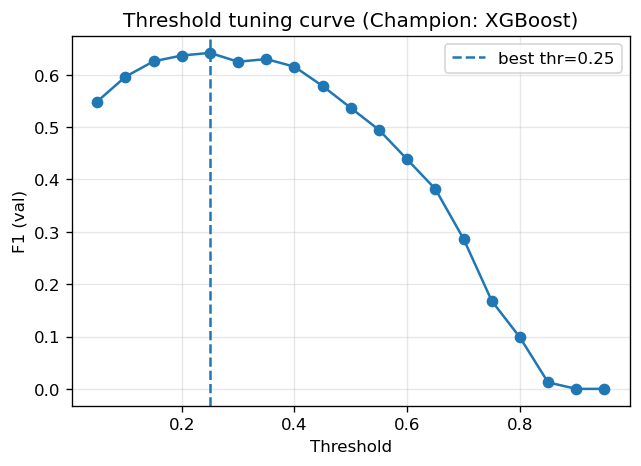

In [46]:
champ_name = thr_df.iloc[0]["model"]
champ_thr  = float(thr_df.iloc[0]["best_thr_val"])
champ_model = results[champ_name][1]

print("Champion:", champ_name)
print("Chosen threshold (val):", champ_thr)

curve = thr_curves[champ_name]
plt.figure()
plt.plot(curve["thr"], curve["F1"], marker="o")
plt.axvline(champ_thr, linestyle="--", label=f"best thr={champ_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 (val)")
plt.title(f"Threshold tuning curve (Champion: {champ_name})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Refit champion sur TRAIN+VAL

In [47]:
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

champ_model_final = clone(champ_model)
champ_model_final.fit(X_trainval, y_trainval)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=-1,
              num_parallel_tree=None, ...)

Test final (une fois) + Confusion matrix (counts + normalized)

=== TEST (final) ===
ACC=0.774 | F1=0.684 | AUC=0.854


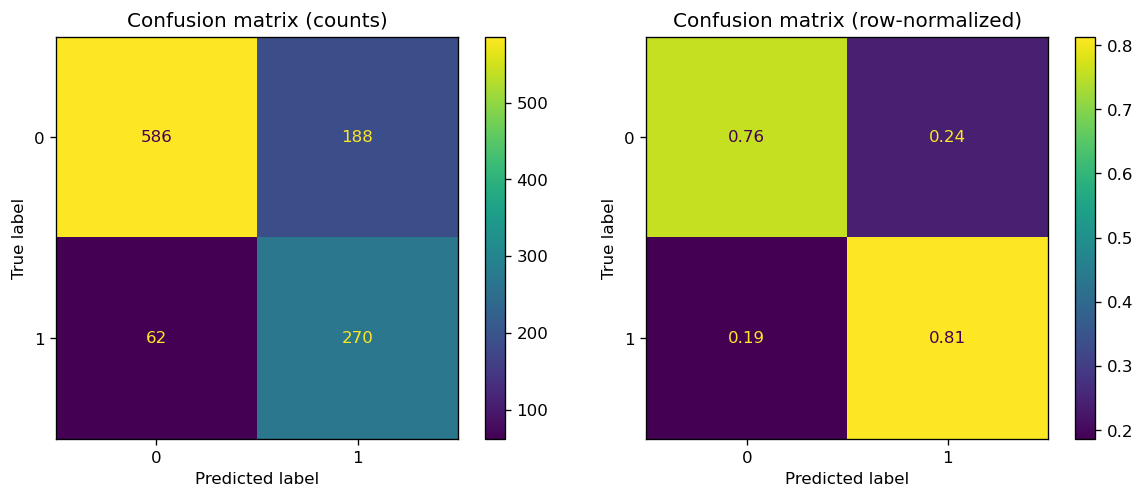

              precision    recall  f1-score   support

           0      0.904     0.757     0.824       774
           1      0.590     0.813     0.684       332

    accuracy                          0.774      1106
   macro avg      0.747     0.785     0.754      1106
weighted avg      0.810     0.774     0.782      1106



In [48]:
test_out = eval_on_split(champ_model_final, X_test, y_test, thr=champ_thr)
print("=== TEST (final) ===")
print(f"ACC={test_out['ACC']:.3f} | F1={test_out['F1']:.3f} | AUC={test_out['AUC']:.3f}")

proba_test = test_out["proba"]
pred_test  = test_out["pred"]

cm = confusion_matrix(y_test, pred_test)
cm_norm = confusion_matrix(y_test, pred_test, normalize="true")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], values_format="d")
ax[0].set_title("Confusion matrix (counts)")

ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], values_format=".2f")
ax[1].set_title("Confusion matrix (row-normalized)")

plt.tight_layout()
plt.show()

print(classification_report(y_test, pred_test, digits=3))


PR curve (AP + point du threshold) — version corrigée

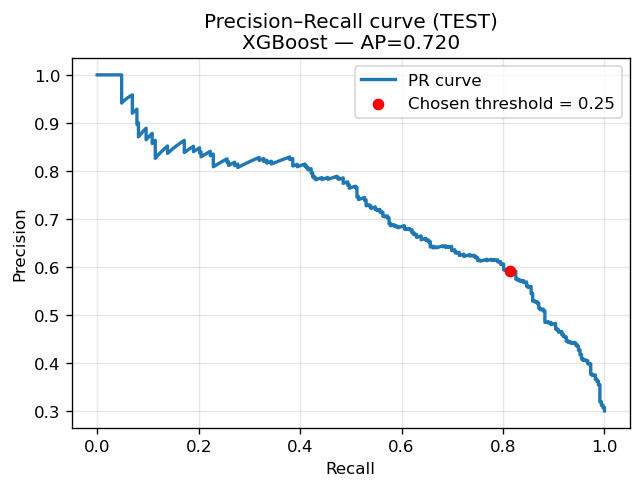

In [49]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

thr_idx = int(np.argmin(np.abs(thresholds_pr - champ_thr)))
pt_recall = recall[thr_idx + 1]
pt_precision = precision[thr_idx + 1]

plt.figure()
plt.plot(recall, precision, lw=2, label="PR curve")
plt.scatter(pt_recall, pt_precision, color="red", zorder=5,
            label=f"Chosen threshold = {champ_thr:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall curve (TEST)\n{champ_name} — AP={ap:.3f}")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


CV final champion (mean ± std) avec threshold fixé

In [50]:
cv_final = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accs, f1s, aucs = [], [], []

for tr, te in cv_final.split(X_used, y_used, groups=groups_used):
    m = clone(champ_model)   # mêmes hyperparams
    m.fit(X_used[tr], y_used[tr])

    proba = m.predict_proba(X_used[te])[:, 1]
    pred  = (proba >= champ_thr).astype(int)

    accs.append(accuracy_score(y_used[te], pred))
    f1s.append(f1_score(y_used[te], pred))
    aucs.append(roc_auc_score(y_used[te], proba))

print("=== Final grouped CV (champion, fixed thr) ===")
print(f"ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


=== Final grouped CV (champion, fixed thr) ===
ACC: 0.759 ± 0.026
F1 : 0.639 ± 0.042
AUC: 0.844 ± 0.015


ablation study

In [51]:
col_to_channel = {c:i for i,c in enumerate(raw_cols)}

def build_flat_from_channels(X_raw, cols_to_keep):
    ch_idx = [col_to_channel[c] for c in cols_to_keep]
    X_sub = X_raw[:, :, ch_idx]
    return X_sub.reshape(X_sub.shape[0], -1)

def eval_subset(cols_to_keep, thr=0.5):
    X_sub = build_flat_from_channels(X_raw, cols_to_keep)
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1s = []
    for tr, te in cv.split(X_sub, y_used, groups=groups_used):
        m = clone(champ_model)
        m.fit(X_sub[tr], y_used[tr])
        proba = m.predict_proba(X_sub[te])[:, 1]
        pred = (proba >= thr).astype(int)
        f1s.append(f1_score(y_used[te], pred))
    return np.mean(f1s), np.std(f1s)

rows = []
for subset in [[raw_cols[0]], [raw_cols[1]], raw_cols]:
    mean_f1, std_f1 = eval_subset(subset, thr=0.5)
    rows.append({"subset": "+".join(subset), "F1_mean": mean_f1, "F1_std": std_f1})

display(pd.DataFrame(rows))


,subset,F1_mean,F1_std
0,Speed,0.564099,0.035338
1,turning_angle,0.215075,0.037754
2,Speed+turning_angle,0.562579,0.032570


Proximity threshold sweep (réutilise segments_from_end)

N= 5 | pos=0.075 | F1=0.220±0.047 | AUC=0.821±0.028
N=10 | pos=0.138 | F1=0.450±0.043 | AUC=0.842±0.019
N=15 | pos=0.200 | F1=0.570±0.033 | AUC=0.844±0.006
N=20 | pos=0.262 | F1=0.639±0.042 | AUC=0.844±0.015
N=25 | pos=0.324 | F1=0.689±0.020 | AUC=0.847±0.010
N=30 | pos=0.388 | F1=0.720±0.035 | AUC=0.840±0.021
N=40 | pos=0.513 | F1=0.764±0.016 | AUC=0.829±0.010


,N_last,pos_rate,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std
0,5,0.075460,0.907724,0.006594,0.219994,0.046592,0.821383,0.028023
1,10,0.138037,0.818950,0.009477,0.449953,0.043341,0.841818,0.018745
2,15,0.199632,0.780748,0.014199,0.569609,0.032891,0.844086,0.005717
3,20,0.261840,0.758522,0.025917,0.639047,0.041768,0.844061,0.014552
4,25,0.324294,0.750048,0.016075,0.688572,0.019920,0.847370,0.009857
5,30,0.387607,0.738990,0.030961,0.720069,0.035187,0.840368,0.020617
6,40,0.513374,0.713147,0.017498,0.763649,0.016395,0.828823,0.010499


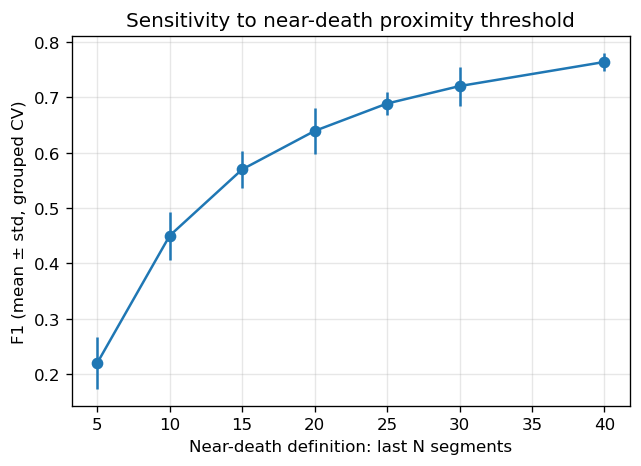

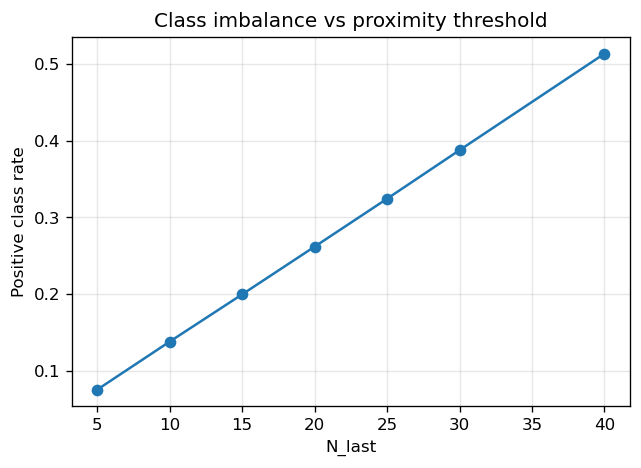

In [52]:
def make_y_near_death(segments_from_end, N_last):
    return (segments_from_end <= N_last).astype(int)

def cv_eval_for_N(model, X, segments_from_end, worm_ids, N_last, thr=0.5, n_splits=5):
    yN = make_y_near_death(segments_from_end, N_last)
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    accs, f1s, aucs = [], [], []

    for tr, te in cv.split(X, yN, groups=worm_ids):
        m = clone(model)
        m.fit(X[tr], yN[tr])
        proba = m.predict_proba(X[te])[:, 1]
        pred  = (proba >= thr).astype(int)

        accs.append(accuracy_score(yN[te], pred))
        f1s.append(f1_score(yN[te], pred))
        aucs.append(roc_auc_score(yN[te], proba))

    return {
        "pos_rate": float(yN.mean()),
        "ACC_mean": float(np.mean(accs)), "ACC_std": float(np.std(accs)),
        "F1_mean": float(np.mean(f1s)),   "F1_std": float(np.std(f1s)),
        "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
    }

N_list = [5, 10, 15, 20, 25, 30, 40]

rows = []
for N_last in N_list:
    res = cv_eval_for_N(champ_model, X_flat, segments_from_end, worm_ids, N_last, thr=champ_thr, n_splits=5)
    rows.append({"N_last": N_last, **res})
    print(f"N={N_last:>2} | pos={res['pos_rate']:.3f} | F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f}")

nearN_df = pd.DataFrame(rows)
display(nearN_df)

plt.figure()
plt.errorbar(nearN_df["N_last"], nearN_df["F1_mean"], yerr=nearN_df["F1_std"], fmt="o-")
plt.xlabel("Near-death definition: last N segments")
plt.ylabel("F1 (mean ± std, grouped CV)")
plt.title("Sensitivity to near-death proximity threshold")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(nearN_df["N_last"], nearN_df["pos_rate"], marker="o")
plt.xlabel("N_last")
plt.ylabel("Positive class rate")
plt.title("Class imbalance vs proximity threshold")
plt.grid(True, alpha=0.3)
plt.show()


life-stage analysis

In [53]:
def compute_normalized_age(worm_ids, segment_indices):
    norm_age = np.zeros_like(segment_indices, dtype=float)
    for wid in np.unique(worm_ids):
        m = (worm_ids == wid)
        idxs = segment_indices[m]
        mx = idxs.max()
        norm_age[m] = 0.0 if mx == 0 else idxs / mx
    return norm_age

def stage_from_norm_age(a):
    if a < 0.25: return "early"
    if a < 0.50: return "mid"
    if a < 0.75: return "late"
    return "very_late"

norm_age_all = compute_normalized_age(worm_ids, segment_indices)
stages_all = np.array([stage_from_norm_age(a) for a in norm_age_all])

print(pd.Series(stages_all).value_counts())


early        2058
very_late    2046
mid          2029
late         2017
Name: count, dtype: int64


Métriques par stage (mean±std): 

,stage,n_mean,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std
0,early,411.6,0.912888,0.021682,0.000000,0.000000,NaN,NaN
2,mid,405.8,0.841607,0.020424,0.000000,0.000000,0.535965,0.069298
1,late,403.4,0.472254,0.090683,0.201159,0.094572,0.488603,0.067855
3,very_late,409.2,0.802400,0.040324,0.888177,0.025343,0.622738,0.050713


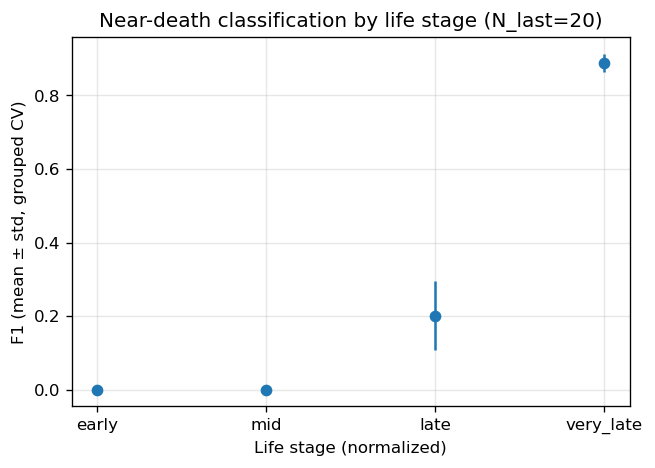

In [54]:
from collections import defaultdict

def stage_metrics_grouped_cv(model, X, y, worm_ids, stages, thr=0.5, n_splits=5):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    per_stage = defaultdict(lambda: {"ACC": [], "F1": [], "AUC": [], "n": []})

    for tr, te in cv.split(X, y, groups=worm_ids):
        m = clone(model)
        m.fit(X[tr], y[tr])
        proba = m.predict_proba(X[te])[:, 1]
        pred  = (proba >= thr).astype(int)

        for st in np.unique(stages):
            mask = (stages[te] == st)
            if mask.sum() < 5:
                continue

            y_true = y[te][mask]
            y_pred = pred[mask]
            y_proba = proba[mask]

            per_stage[st]["n"].append(int(mask.sum()))
            per_stage[st]["ACC"].append(accuracy_score(y_true, y_pred))
            per_stage[st]["F1"].append(f1_score(y_true, y_pred))
            if len(np.unique(y_true)) == 2:
                per_stage[st]["AUC"].append(roc_auc_score(y_true, y_proba))

    rows = []
    for st, d in per_stage.items():
        rows.append({
            "stage": st,
            "n_mean": np.mean(d["n"]),
            "ACC_mean": np.mean(d["ACC"]), "ACC_std": np.std(d["ACC"]),
            "F1_mean": np.mean(d["F1"]),   "F1_std": np.std(d["F1"]),
            "AUC_mean": np.mean(d["AUC"]) if len(d["AUC"]) else np.nan,
            "AUC_std": np.std(d["AUC"]) if len(d["AUC"]) else np.nan,
        })
    return pd.DataFrame(rows)

N_for_stage = 20
y_stage = make_y_near_death(segments_from_end, N_for_stage)

stage_df = stage_metrics_grouped_cv(champ_model, X_flat, y_stage, worm_ids, stages_all, thr=champ_thr, n_splits=5)
order = ["early", "mid", "late", "very_late"]
stage_df["stage"] = pd.Categorical(stage_df["stage"], categories=order, ordered=True)
stage_df = stage_df.sort_values("stage")
display(stage_df)

plt.figure()
plt.errorbar(stage_df["stage"], stage_df["F1_mean"], yerr=stage_df["F1_std"], fmt="o")
plt.xlabel("Life stage (normalized)")
plt.ylabel("F1 (mean ± std, grouped CV)")
plt.title(f"Near-death classification by life stage (N_last={N_for_stage})")
plt.grid(True, alpha=0.3)
plt.show()
